## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, molal, molar,grams,milliliter,kilogram
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_63859/3824394281.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*             

## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u2 = mda.Universe('md2m.gro', 'md2m.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('md3m.gro', 'md3m.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

In [4]:
# ions_z = ions.positions[:,2]
#     zpositions=[]

#     for _ in u.trajectory:
#         ions_z = ions.positions[:,2]*angstrom
#         zpositions.append(ions_z)

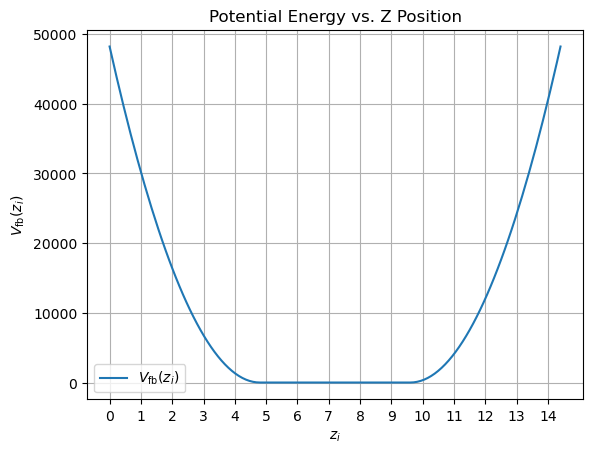

In [5]:
#calculate flat-bottom potential energy
def V_fb(zi, Ri_z, k_fb, r_fb):
    """
    Calculates the potential energy for force between particles based on z positions.

    Returns:
        float: Potential energy.
    """
    d_zi_Ri = abs(zi - Ri_z)
    delta = d_zi_Ri - r_fb
    heaviside_value = heaviside_step(delta)
    return 0.5 * k_fb * (delta ** 2) * heaviside_value

#heaviside step function
def heaviside_step(x):
    return 1 if x >= 0 else 0

Ri_z=7.2
k_fb=4184
r_fb=2.4

#z positions
#zi_values = ions_z._value
#zi_values=zi_values.sort()
zi_values = np.linspace(0, 14.4, 130)

#potential energy for each z position
potential_energy_values = [V_fb(zi, Ri_z, k_fb, r_fb) for zi in zi_values]


plt.plot(zi_values, potential_energy_values, label=r'$V_{\mathrm{fb}}(z_i)$')
plt.xlabel(r'$z_i$')
plt.ylabel(r'$V_{\mathrm{fb}}(z_i)$')
plt.title('Potential Energy vs. Z Position')
plt.xticks(np.arange(0, 14.4, 1.0))
plt.legend()
plt.grid(True)
plt.show()


## Density Plots

In [6]:
def molal_to_molar(molal_concentration:Quantity=1*(mole/kilogram), solvent_density:Quantity=1*(grams/milliliter)):
    solvent_density_kg_per_L = solvent_density.in_units_of(kilogram/litre)
    molar_concentration = molal_concentration / solvent_density_kg_per_L
    return molar_concentration

def molar_to_molal(molar_concentration:Quantity=1*(mole/milliliter), solvent_density:Quantity=1*(grams/milliliter)):
    solvent_density_kg_per_L = solvent_density.in_units_of(kilogram/litre)
    molal_concentration = molar_concentration * solvent_density_kg_per_L
    return molal_concentration


nacl_dens_1m=1.03621*(grams/milliliter)
nacl_dens_2m=1.07227*(grams/milliliter)
nacl_dens_3m=1.10579*(grams/milliliter)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.16693311
 1.0553196  1.02156011 1.04505582 1.03069685 1.04860039 1.02193005
 1.02342703 1.02044168 0.993952   1.00757108 0.95366258 0.98742207
 1.00439645 0.9926443  0.99376273 1.00701187 0.9926443  0.99433055
 0.99786652 0.98219985 0.95273342 0.95254415 0.94899957 0.92531459
 0.15051966 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ] kg mol/(L**2)


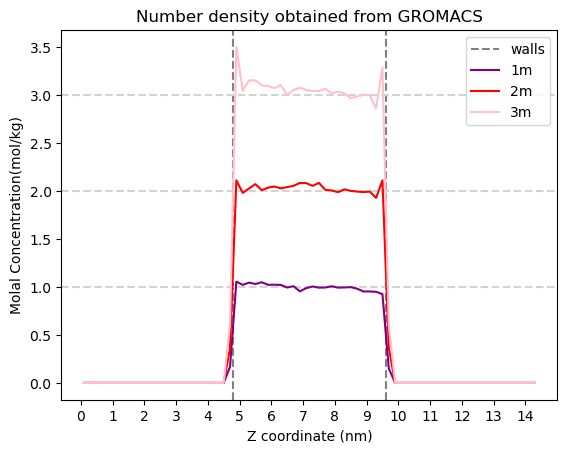

In [7]:

# x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
# y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
# y=y.in_units_of(mole/litre)/2
# y=molar_to_molal(y,nacl_dens_1m)
# print(y)
# x1,y1 = np.loadtxt("dens_2m.xvg",comments=["@", "#"],unpack=True)
# y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
# y1=y1.in_units_of(mole/litre)/2
# y1=molar_to_molal(y1,nacl_dens_2m)
# x2,y2 = np.loadtxt("dens_3m.xvg",comments=["@", "#"],unpack=True)
# y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
# y2=y2.in_units_of(mole/litre)/2
# y2=molar_to_molal(y2,nacl_dens_3m)
# plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
# plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
# plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
# plt.axhline(y = 2, color = 'lightgray', linestyle = 'dashed')
# plt.axhline(y = 3, color = 'lightgray', linestyle = 'dashed')
# # plt.plot(zi_values, potential_energy_values, label=r'$V_{\mathrm{fb}}(z_i)$')
# plt.plot(x,y, c='purple', label='1m')
# plt.plot(x1,y1, c='red', label='2m')
# plt.plot(x2,y2, c='pink', label='3m')
# plt.xlabel("Z coordinate (nm)")
# plt.ylabel("Molal Concentration(mol/kg)")
# plt.xticks(np.arange(0, 14.4, 1.0))
# #plt.yticks(np.arange(0.0, 1.0, 0.1))
# plt.title('Number density obtained from GROMACS')
# plt.legend(loc='upper right')
# plt.show()


In [1]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_2m.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_3m.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 0.98, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 1.92, color = 'lightgray', linestyle = 'dashed')
plt.axhline(y = 2.83, color = 'lightgray', linestyle = 'dashed')
# plt.plot(zi_values, potential_energy_values, label=r'$V_{\mathrm{fb}}(z_i)$')
plt.plot(x,y, c='mediumpurple', label='1m')
plt.plot(x1,y1, c='blueviolet', label='2m')
plt.plot(x2,y2, c='indigo', label='3m')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Molal Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
#plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.title('Increasing Concentration - CHARMM27')
plt.legend(loc='upper right')
plt.show()

NameError: name 'np' is not defined

## Density plot using MDanalysis

In [ ]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [ ]:
# nbins,ncounts=density_profile(u,ions, bin_width=2, dim='z', method='atoms', frameby=1)
# nbins2,ncounts2=density_profile(u2,ions2, bin_width=2, dim='z', method='atoms', frameby=1)
# nbins3,ncounts3=density_profile(u3,ions3, bin_width=2, dim='z', method='atoms', frameby=1)



In [ ]:
volbin=48*48*2*angstrom**3
# conc=ncounts*mole/volbin
# print(conc.in_units_of(mole/litre))

In [ ]:
plt.plot(nbins[1:],ncounts, c='purple', label='1m')
plt.plot(nbins2[1:],ncounts2, c='red', label='2m')
plt.plot(nbins3[1:],ncounts3, c='pink', label='3m')


plt.xlabel("Z coordinate (Angstroms)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 144, 10))
plt.title("Number density plotted with MDAnalysis")
plt.legend()
plt.show()

NameError: name 'nbins' is not defined

In [ ]:

counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='purple', label='1m')
plt.plot(bins2[1:],counts2, c='red', label='2m')
plt.plot(bins3[1:],counts3, c='pink', label='3m')


plt.xlabel("Z coordinate (Angstroms)")
plt.ylabel("Concentration (M)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile increasing concentration")
plt.legend()
plt.show()